In [1]:
%matplotlib notebook
import pathlib
from copy import copy
from openpmd_viewer import addons
from matplotlib import pyplot as plt, colors, cm, rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import unyt as u
from prepic import lwfa
import numpy as np
from scipy.signal import hilbert
import custom_colormap as cc
import figformat
import plasma_constants as pc

In [2]:
fig_width, fig_height, params = figformat.figure_format(fig_width=3.4,fig_height=3.4)
rcParams.update(params)

In [3]:
cc.colormap_alpha('Reds')

In [4]:
a0 = 2.4   # Laser amplitude
tau = 25.0e-15 / 2.354820045 # Laser duration
w0 = 22.0e-6 / 1.17741 # Laser waist
lambda0 = 0.8e-6 # Laser wavelength
print(lambda0)

8e-07


1.87830854350318


<IPython.core.display.Javascript object>


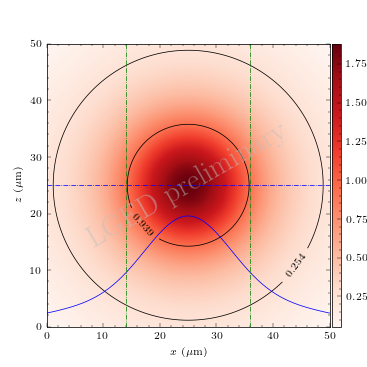

/home/ong/.anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: The following kwargs were not used by contour: 'label'


In [13]:
def Laguerre_mode(n,X):
    if n==0:
        return 1
    elif n==1:
        return 1 - X
    elif n==2:
        return 0.5 * (X**2- 4*X +2)
    elif n==3:
        return (1/6) * (-X**3 + 9*X**2 - 18*X + 6)   

LAGUERREMODES = np.array([-1.0,0.31,-0.2])
MODE_NUMBER = LAGUERREMODES.shape

def LaguerreBeam(m,x,z,y_focused,xinit):
    k = 2.0 * pc.pi /lambda0
    # Gaussian Beam stuff
    zinit = xinit 
    radius = np.sqrt((x-xinit)**2 + (z-zinit)**2)            # radius of laser spot
    radius2 = radius**2
    posY = y_focused
    rayleigh_range = pc.pi * w0**2 / lambda0
    wz = w0 * np.sqrt(1+(posY/rayleigh_range)**2)
    wz2 = wz**2
    radius_of_curvature = posY * (1.0+(rayleigh_range/posY)**2)
    PsiG = np.arctan(posY/rayleigh_range)
    phase = (k * radius2/(2.0 * radius_of_curvature)) - (2*0 + 1)*PsiG
    if m==0:
        Etrans = LAGUERREMODES[0]*Laguerre_mode(0,2*radius2/(wz2))*(w0/wz)*np.exp(-radius2/wz2)
    elif m==1:
        Etrans = (LAGUERREMODES[0]*Laguerre_mode(0,2*radius2/(wz2)) + 
                  LAGUERREMODES[1]*Laguerre_mode(1,2*radius2/(wz2)) )*(w0/wz)*np.exp(-radius2/wz2)
    elif m==2:
        Etrans = (LAGUERREMODES[0]*Laguerre_mode(0,2*radius2/(wz2)) + 
                  LAGUERREMODES[1]*Laguerre_mode(1,2*radius2/(wz2)) +
                  LAGUERREMODES[2]*Laguerre_mode(2,2*radius2/(wz2)) )*(w0/wz)*np.exp(-radius2/wz2)
    return Etrans

x = np.linspace(0,50e-6,256)
z = np.linspace(0,50e-6,256)
X, Z = np.meshgrid(x,z)
extent = np.min(X*1e6), np.max(X*1e6), np.min(Z*1e6), np.max(Z*1e6)
Intensity = a0*LaguerreBeam(2,X,Z,y_focused=150e-6,xinit=25e-6)**2
print(np.max(Intensity))

fig, ax = plt.subplots()

im_envelope = ax.imshow(
    Intensity,
    extent=extent,
    origin="lower",
    cmap='Reds')

cbaxes_env = inset_axes(
    ax,
    width="3%",  # width = 5% of parent_bbox width
    height="100%",  # height : 50%
    loc=3,
    bbox_to_anchor=(1.01, 0.0, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
cbar_env = fig.colorbar(
    mappable=im_envelope, orientation="vertical", ticklocation="right", cax=cbaxes_env
)
cbar_env.set_label("$a_0$")
cbar_env.ax.minorticks_on()

ax.plot(x*1e6, Intensity[128,:]/a0*25,color="b")
ax.axhline(25, color="b", ls="-.")
ax.axvline(14, color="g", ls="-.")
ax.axvline(36, color="g", ls="-.")
img2 = ax.contour(
    x * 1e6,
    z * 1e6,
    Intensity,
    levels=[0.135*np.max(Intensity),0.5*np.max(Intensity)],
    colors="black",
    label="$d_\mathrm{FWHM}$",
)
ax.clabel(img2, inline=1)
# add watermark
ax.text(0.5, 0.5, 'LGED preliminary', transform=ax.transAxes,
    fontsize=20, color='0.75', alpha=0.5,
    ha='center', va='center', rotation='30')

# Add the name of the axes
ax.set_ylabel("$z \;(\mu \mathrm{m} )$")
ax.set_xlabel("$x \;(\mu \mathrm{m} )$")
ax.minorticks_on()
plt.show()

In [14]:
fig.savefig(
    rf"Laguerre_Gaissian_mode{LAGUERREMODES.shape[0]-1}.png",
    dpi=600,
    transparent=False,
    bbox_inches="tight",
)
plt.close()